In [2]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vlsp2018-hotel/3-VLSP2018-SA-Hotel-test.csv
/kaggle/input/vlsp2018-hotel/2-VLSP2018-SA-Hotel-dev.csv
/kaggle/input/vlsp2018-hotel/1-VLSP2018-SA-Hotel-train.csv


In [3]:
!pip install -q emoji
!pip install -q vncorenlp
!pip install -q datasets
!pip install -q accelerate
!pip install -q transformers
!pip install vncorenlp

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
!git clone https://github.com/ds4v/absa-vlsp-2018.git
%cd ./absa-vlsp-2018/experiments
!mkdir predictions
!ls

Cloning into 'absa-vlsp-2018'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 255 (delta 27), reused 40 (delta 24), pack-reused 201 (from 1)
Receiving objects: 100% (255/255), 32.07 MiB | 39.19 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/kaggle/working/absa-vlsp-2018/experiments
mkdir: cannot create directory 'predictions': File exists
Hotel-v1.ipynb	Restaurant-v1.ipynb  predictions
Hotel-v2.ipynb	Restaurant-v2.ipynb


In [4]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
sys.path.append('..')
tf.__version__

'2.16.1'

In [7]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    !nvcc -V
else: raise ValueError('Running on CPU is not recommended.')

Using GPU: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [48]:
TRAIN_PATH = r'/kaggle/input/vlsp2018-hotel/3-VLSP2018-SA-Hotel-test.csv'  # Nhớ đổi lại data path, data nặng vcl =))
VAL_PATH = r'/kaggle/input/vlsp2018-hotel/3-VLSP2018-SA-Hotel-test.csv'
TEST_PATH = r'/kaggle/input/vlsp2018-hotel/3-VLSP2018-SA-Hotel-test.csv'
PRETRAINED_MODEL = 'vinai/phobert-base'
MODEL_NAME = 'Hotel-v1' # Multitask model on Hotel domain
MAX_LENGTH = 256
BATCH_SIZE = 128
EPOCHS = 10

In [30]:
%cd /kaggle/working/absa-vlsp-2018

/kaggle/working/absa-vlsp-2018


In [31]:
%pwd

'/kaggle/working/absa-vlsp-2018'

In [32]:
from processors.vlsp2018_processor import VLSP2018Loader
raw_datasets = VLSP2018Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL'],
        num_rows: 600
    })
    val: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURE

In [25]:
!pip install vncorenlp

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=b2d076d9cf9f1207460769e1aee67a6eaa095f296338479fc340de4140b5e2ee
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [33]:
from processors.vietnamese_processor import VietnameseTextPreprocessor
vn_preprocessor = VietnameseTextPreprocessor(vncorenlp_dir='../processor/VnCoreNLP', extra_teencodes={
    'khách sạn': ['ks'], 'nhà hàng': ['nhahang'], 'nhân viên': ['nv'],
    'cửa hàng': ['store', 'sop', 'shopE', 'shop'],
    'sản phẩm': ['sp', 'product'], 'hàng': ['hàg'],
    'giao hàng': ['ship', 'delivery', 'síp'], 'đặt hàng': ['order'],
    'chuẩn chính hãng': ['authentic', 'aut', 'auth'], 'hạn sử dụng': ['date', 'hsd'],
    'điện thoại': ['dt'],  'facebook': ['fb', 'face'],
    'nhắn tin': ['nt', 'ib'], 'trả lời': ['tl', 'trl', 'rep'],
    'feedback': ['fback', 'fedback'], 'sử dụng': ['sd'], 'xài': ['sài'],
}, max_correction_length=MAX_LENGTH)

2024-10-20 02.34.19 INFO VnCoreNLPServer - Using annotators: wseg
2024-10-20 02:34:19 INFO  WordSegmenter:24 - Loading Word Segmentation model
2024-10-20 02.34.20 INFO VnCoreNLPServer - VnCoreNLPServer is listening on http://127.0.0.1:57023
2024-10-20 02.34.20 INFO log - Logging initialized @744ms to org.eclipse.jetty.util.log.Slf4jLog
2024-10-20 02.34.20 INFO EmbeddedJettyServer - == Spark has ignited ...
2024-10-20 02.34.20 INFO EmbeddedJettyServer - >> Listening on 127.0.0.1:57023
2024-10-20 02.34.20 INFO Server - jetty-9.4.z-SNAPSHOT, build timestamp: 2017-11-21T21:27:37Z, git hash: 82b8fb23f757335bb3329d540ce37a2a2615f0a8
2024-10-20 02.34.20 INFO session - DefaultSessionIdManager workerName=node0
2024-10-20 02.34.20 INFO session - No SessionScavenger set, using defaults
2024-10-20 02.34.20 INFO session - Scavenging every 600000ms
2024-10-20 02.34.20 INFO AbstractConnector - Started ServerConnector@78297970{HTTP/1.1,[http/1.1]}{127.0.0.1:57023}
2024-10-20 02.34.20 INFO Server - Sta

In [35]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokens = tokenizer.encode('Tôi là thành_viên nhóm hackathon MetaMind .')
print('Encode:', tokens, '\nDecode:', tokenizer.decode(tokens))
tokenizer.model_input_names

Encode: [0, 218, 8, 496, 276, 1340, 12205, 56020, 11094, 1850, 6466, 2158, 5, 2] 
Decode: <s> Tôi là thành_viên nhóm hackathon MetaMind . </s>


['input_ids', 'token_type_ids', 'attention_mask']

In [36]:
preprocessed_datasets = VLSP2018Loader.preprocess_and_tokenize(raw_datasets, vn_preprocessor, tokenizer, BATCH_SIZE * 2, MAX_LENGTH)
preprocessed_datasets.save_to_disk('../datasets/preprocessed_hotel')
display(preprocessed_datasets)

[INFO] Preprocessing and tokenizing text data...


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 600
    })
    val: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT

In [38]:
pd.DataFrame({
    'raw_datasets': raw_datasets['train']['Review'][480:490],
    'encoded_input_ids': preprocessed_datasets['train']['input_ids'][480:490],
    'decoded_input_ids': [tokenizer.decode(preprocessed_datasets['train'][i]['input_ids']) for i in range(480, 490)]
})

,raw_datasets,encoded_input_ids,decoded_input_ids
0,"View đẹp,sạch sẽ,nhân viên thân thiện nhiệt tì...","[0, 9328, 258, 4767, 650, 3188, 3857, 1339, 29...",<s> view đẹp sạch_sẽ nhân_viên thân_thiện nhiệ...
1,"Bữa sáng ngon. View đẹp, cạnh nhiều nhà hàng h...","[0, 1339, 298, 1325, 9328, 258, 362, 36, 69, 1...",<s> bữa sáng ngon view đẹp cạnh nhiều nhà hàg ...
2,"View đẹp Hành lang không sạch sẽ, mùi ẩm mốc","[0, 9328, 258, 3967, 17, 4767, 1602, 31631, 2,...",<s> view đẹp hành_lang không sạch_sẽ mùi ẩm_mố...
3,"Nhân viên nhiệt tình, chu đáo, thân thiện. Phò...","[0, 650, 3857, 5655, 3188, 292, 1681, 258, 115...",<s> nhân_viên nhiệt_tình chu_đáo thân_thiện ph...
4,"Nhân viên phục vụ ân cần, lịch sự. Không gian ...","[0, 650, 533, 13647, 8502, 1152, 15646, 9328, ...",<s> nhân_viên phục_vụ ân_cần lịch_sự không_gia...
5,"Phòng có 2 vị trí cửa sổ ngắm về phía Đà Nẵng,...","[0, 292, 10, 76, 442, 4185, 2381, 28, 216, 622...",<s> phòng có 2 vị_trí cửa_sổ ngắm về phía đà_n...
6,"Hai nhân viên lễ tân, có một nhân viên rất nhi...","[0, 82, 650, 17112, 10, 16, 650, 59, 3857, 50,...",<s> hai nhân_viên lễ_tân có một nhân_viên rất ...
7,Giường rộng thoải mái. Phòng đầy đủ tiện nghi....,"[0, 2639, 720, 1937, 292, 997, 6689, 124, 262,...",<s> giường rộng thoải_mái phòng đầy_đủ tiện_ng...
8,"Nhân viên thân thiện, nhiệt tình. Giá phòng hợ...","[0, 650, 3188, 3857, 133, 292, 1640, 5959, 57,...",<s> nhân_viên thân_thiện nhiệt_tình giá phòng ...
9,Gần biển và cũng gần trung tâm luôn. Mình thuê...,"[0, 124, 262, 6, 32, 124, 591, 236, 68, 684, 9...",<s> gần biển và cũng gần trung_tâm luôn mình t...


# Extra Step for ACSA-v1 Solution

In [39]:
from datasets import load_from_disk
preprocessed_datasets = load_from_disk('../datasets/preprocessed_hotel')
preprocessed_datasets = VLSP2018Loader.labels_to_flatten_onehot(preprocessed_datasets)
preprocessed_datasets

[INFO] Transforming "Aspect#Categoy,Polarity" labels to flattened one-hot encoding...


/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/600 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/600 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 600
    })
    val: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 600
    })
    test: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 600
    })
})

In [40]:
print('Aspect#Category,Polarity in One-hot form of the first review:')
example_onehot = preprocessed_datasets['train'][0]['FlattenOneHotLabels']
np.array(example_onehot).reshape(-1, 4)

Aspect#Category,Polarity in One-hot form of the first review:


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

# Prepare for Tensorflow Training

In [41]:
ASPECT_CATEGORY_NAMES = raw_datasets['train'].column_names[1:]
steps_per_epoch = len(preprocessed_datasets['train']) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
print(ASPECT_CATEGORY_NAMES)

['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL']


In [43]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=CosineDecay(
    initial_learning_rate = 1e-4,
    warmup_target = 2e-4,
    warmup_steps = int(total_steps * 0.15), # 15% of total_steps
    decay_steps = int(total_steps * 0.3), # Next 30% of total_steps
    alpha = 0.1, # Minimum lr for decay as a fraction of initial_learning_rate
))

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3, # Stop if no improvement after 3 epochs
    restore_best_weights = True, # You may obtain HIGHER metrics on the test set with longer training time if you set this to False
    # Because after some experiments, I found that even with higher val_loss, it still results in better metric reports on the test set. 
    # This maybe because the training set and the test set have more similarities than the validation data.
    # But I think this is not fair, as we already have prior knowledge about the test set and we modified our training based on the performance on this set. 
    # In real-world, we should only modify our training based on the performance on the validation data
    verbose = 1
)

# Fine-tuning with Tensorflow

In [45]:
!pip install dropbox

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.1/572.1 kB 12.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00


In [46]:
%%time
from acsa_model import VLSP2018MultiTask
from helper import plot_training_history
model = VLSP2018MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)

history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    callbacks = [early_stop_callback],
    epochs = EPOCHS,
    verbose = 1
).history

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3


I0000 00:00:1729393014.880708     986 service.cc:145] XLA service 0x78f350012c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729393014.880762     986 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1729393017.334527     986 assert_op.cc:38] Ignoring Assert operator Hotel-v1_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert
I0000 00:00:1729393026.170170     986 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - loss: 0.5535

W0000 00:00:1729393030.491630     986 assert_op.cc:38] Ignoring Assert operator Hotel-v1_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5475   

W0000 00:00:1729393051.727891     985 assert_op.cc:38] Ignoring Assert operator Hotel-v1_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert
W0000 00:00:1729393058.564335     987 assert_op.cc:38] Ignoring Assert operator Hotel-v1_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert


5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - loss: 0.5434 - val_loss: 0.4703
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - loss: 0.4663 - val_loss: 0.4528
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - loss: 0.4488 - val_loss: 0.4358
Restoring model weights from the end of the best epoch: 3.
CPU times: user 1min 14s, sys: 2.4 s, total: 1min 16s
Wall time: 2min 12s


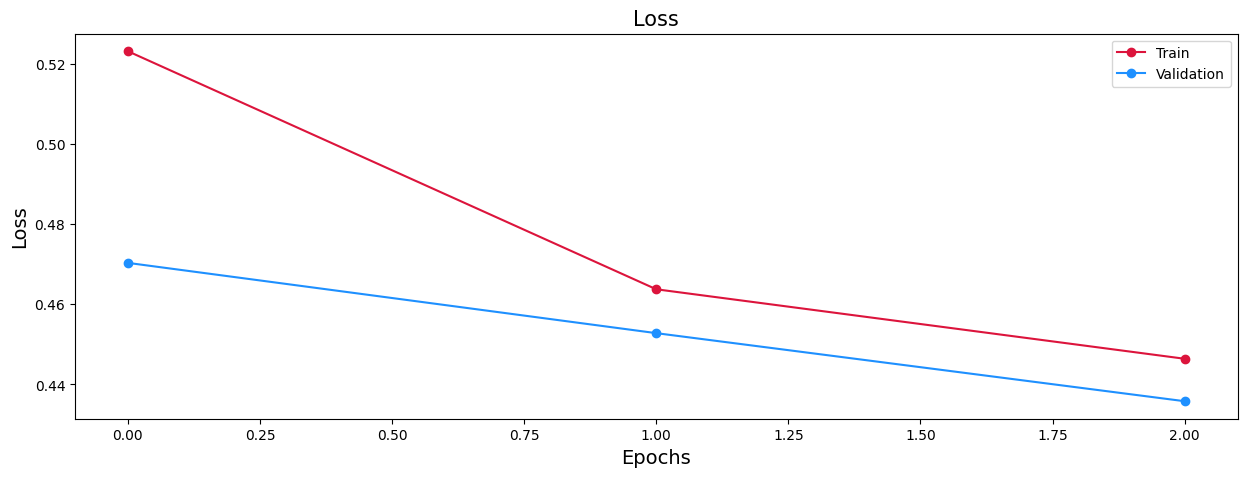

In [53]:
import os

# Directory where you want to save the model weights
weights_dir = './weights/Hotel-v1/'

# Check if the directory exists, if not, create it
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

# Now save the model weights
model.save_weights(f'{weights_dir}/Hotel-v1.weights.h5')

# Plot the training history
plot_training_history(history)


In [57]:
import dropbox

DROPBOX_ACCESS_TOKEN = 'YOUR_ACCESS_TOKEN_HERE'
dbx = dropbox.Dropbox(DROPBOX_ACCESS_TOKEN)

file_weight_path = f'./weights/{MODEL_NAME}/{MODEL_NAME}.weights.h5'
dropbox_destination_path = f'/Apps/VLSP2018/{MODEL_NAME}/weights.h5'

with open(file_weight_path, 'rb') as f:
    dbx.files_upload(f.read(), dropbox_destination_path, mute=True)

print(f"File '{file_weight_path}' uploaded successfully to Dropbox at '{dropbox_destination_path}'.")

File './weights/Hotel-v1/Hotel-v1.weights.h5' uploaded successfully to Dropbox at '/Apps/VLSP2018/Hotel-v1/weights.h5'.


# Predict on Test Data

In [58]:
from acsa_model import VLSP2018MultiTask
reloaded_model = VLSP2018MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)
reloaded_model.load_weights(f'./weights/{MODEL_NAME}/{MODEL_NAME}.weights.h5') # Reload the Model
reloaded_model.evaluate(val_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
W0000 00:00:1729393406.541058     985 assert_op.cc:38] Ignoring Assert operator Hotel-v1_1/tf_roberta_model_1/roberta/embeddings/assert_less/Assert/Assert


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - loss: 0.5631

W0000 00:00:1729393413.476961     988 assert_op.cc:38] Ignoring Assert operator Hotel-v1_1/tf_roberta_model_1/roberta/embeddings/assert_less/Assert/Assert


5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.5631


0.5632318258285522

In [59]:
y_pred = reloaded_model.acsa_predict(test_tf_dataset, BATCH_SIZE) # On test set
reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
print('Example:', raw_datasets['test'][0]['Review'])
reloaded_model.print_acsa_pred(y_pred[0])

W0000 00:00:1729393434.197336     986 assert_op.cc:38] Ignoring Assert operator Hotel-v1_1/tf_roberta_model_1/roberta/embeddings/assert_less/Assert/Assert


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step

W0000 00:00:1729393442.593930     985 assert_op.cc:38] Ignoring Assert operator Hotel-v1_1/tf_roberta_model_1/roberta/embeddings/assert_less/Assert/Assert


5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 782ms/step - loss: 0.5631
Example: Ga giường không sạch, nhân viên quên dọn phòng một ngày.
=> FACILITIES#CLEANLINESS,positive
=> FACILITIES#COMFORT,neutral
=> FACILITIES#DESIGN&FEATURES,neutral
=> FACILITIES#GENERAL,neutral
=> FACILITIES#PRICES,negative
=> FACILITIES#QUALITY,positive
=> FOOD&DRINKS#MISCELLANEOUS,negative
=> FOOD&DRINKS#PRICES,positive
=> FOOD&DRINKS#QUALITY,negative
=> HOTEL#COMFORT,neutral
=> HOTEL#GENERAL,neutral
=> HOTEL#MISCELLANEOUS,positive
=> HOTEL#PRICES,neutral
=> HOTEL#QUALITY,positive
=> LOCATION#GENERAL,neutral
=> ROOMS#CLEANLINESS,positive
=> ROOMS#COMFORT,negative
=> ROOMS#DESIGN&FEATURES,negative
=> ROOMS#GENERAL,positive
=> ROOMS#QUALITY,neutral
=> ROOM_AMENITIES#CLEANLINESS,positive
=> ROOM_AMENITIES#DESIGN&FEATURES,negative
=> ROOM_AMENITIES#GENERAL,neutral
=> ROOM_AMENITIES#MISCELLANEOUS,negative
=> ROOM_AMENITIES#PRICES,positive
=> SERVICE#GENERAL,positive


In [ ]:
from tensorflow.data import Dataset # On a random review by user
random_input = VLSP2018Loader.preprocess_and_tokenize(
    input('Enter your review: '), vn_preprocessor, tokenizer,
    batch_size=1, max_length=MAX_LENGTH
)
tf_inputs = Dataset.from_tensor_slices({x: [[random_input[x][0]]] for x in tokenizer.model_input_names})
random_pred = reloaded_model.acsa_predict(tf_inputs)
reloaded_model.print_acsa_pred(random_pred[0])

# Scikit-learn evaluation

In [61]:
from helper import argmax_label_matrix
y_test = argmax_label_matrix(preprocessed_datasets['test']['FlattenOneHotLabels'])
y_test

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [62]:
from evaluators.sklearn_evaluator import VLSP2018SklearnEvaluator
sk_eval = VLSP2018SklearnEvaluator(y_test, y_pred, ASPECT_CATEGORY_NAMES)
# sk_eval.report(report_type='Aspect#Category,Polarity').round(3)
# sk_eval.report(report_type='Aspect#Category').round(3)
# sk_eval.report(report_type='Polarity').round(3)
# sk_eval.report(report_type='macro_avg').round(3)
sk_eval.report(report_type='all')

100%|██████████| 37/37 [00:00<00:00, 40785.61it/s]


ACSA Report (w/o "None" polarity) 
 Aspect#Category 
 Aspect#Category,Polarity 
 
 
 precision recall f1-score support precision recall f1-score support 
 
 
 
 FACILITIES#CLEANLINESS,positive 
 0.009 0.800 0.019 5 
 0.003 0.500 0.006 2 
 
 
 
 FACILITIES#CLEANLINESS,neutral 
 
 0.000 1.000 0.000 0 
 
 
 
 FACILITIES#CLEANLINESS,negative 
 
 0.000 0.000 0.000 3 
 
 
 
 FACILITIES#COMFORT,positive 
 0.042 0.962 0.081 26 
 0.000 0.000 0.000 20 
 
 
 
 FACILITIES#COMFORT,neutral 
 
 0.000 1.000 0.000 0 
 
 
 
 FACILITIES#COMFORT,negative 
 
 0.010 0.167 0.019 6 
 
 
 
 FACILITIES#DESIGN&FEATURES,positive 
 0.107 0.938 0.192 65 
 0.083 0.658 0.147 38 
 
 
 
 FACILITIES#DESIGN&FEATURES,neutral 
 
 0.008 0.400 0.015 5 
 
 
 
 FACILITIES#DESIGN&FEATURES,negative 
 
 0.000 0.000 0.000 22 
 
 
 
 FACILITIES#GENERAL,positive 
 0.035 0.905 0.067 21 
 0.028 0.421 0.053 19 
 
 
 
 FACILITIES#GENERAL,neutral 
 
 0.000 0.000 0.000 1 
 
 
 
 FACILITIES#GENERAL,negative 
 
 0.000 0.000 0.000 1 
 
 
 
 FACILITIES#MISCELLANEOUS,positive 
 0.000 0.000 0.000 8 
 0.000 0.000 0.000 3 
 
 
 
 FACILITIES#MISCELLANEOUS,neutral 
 
 0.000 1.000 0.000 0 
 
 
 
 FACILITIES#MISCELLANEOUS,negative 
 
 0.000 0.000 0.000 5 
 
 
 
 FACILITIES#PRICES,positive 
 0.028 0.462 0.053 13 
 0.000 0.000 0.000 8 
 
 
 
 FACILITIES#PRICES,neutral 
 
 0.000 0.000 0.000 2 
 
 
 
 FACILITIES#PRICES,negative 
 
 0.005 0.333 0.011 3 
 
 
 
 FACILITIES#QUALITY,positive 
 0.083 0.863 0.151 51 
 0.038 0.667 0.071 24 
 
 
 
 FACILITIES#QUALITY,neutral 
 
 0.000 0.000 0.000 2 
 
 
 
 FACILITIES#QUALITY,negative 
 
 0.000 0.000 0.000 25 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,positive 
 0.006 1.000 0.012 3 
 0.019 1.000 0.037 1 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,neutral 
 
 0.000 1.000 0.000 0 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,negative 
 
 0.005 1.000 0.009 2 
 
 
 
 FOOD&DRINKS#PRICES,positive 
 0.015 1.000 0.030 9 
 0.000 0.000 0.000 6 
 
 
 
 FOOD&DRINKS#PRICES,neutral 
 
 0.000 1.000 0.000 0 
 
 
 
 FOOD&DRINKS#PRICES,negative 
 
 0.002 0.333 0.004 3 
 
 
 
 FOOD&DRINKS#QUALITY,positive 
 0.215 0.457 0.292 129 
 0.067 0.010 0.018 96 
 
 
 
 FOOD&DRINKS#QUALITY,neutral 
 
 0.048 0.143 0.071 14 
 
 
 
 FOOD&DRINKS#QUALITY,negative 
 
 0.037 0.421 0.068 19 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,positive 
 0.073 0.024 0.036 124 
 0.000 0.000 0.000 43 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,neutral 
 
 0.000 0.000 0.000 6 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,negative 
 
 0.083 0.013 0.023 75 
 
 
 
 HOTEL#CLEANLINESS,positive 
 0.054 0.030 0.038 67 
 1.000 0.000 0.000 59 
 
 
 
 HOTEL#CLEANLINESS,neutral 
 
 0.000 1.000 0.000 0 
 
 
 
 HOTEL#CLEANLINESS,negative 
 
 0.000 0.000 0.000 8 
 
 
 
 HOTEL#COMFORT,positive 
 0.157 1.000 0.271 94 
 1.000 0.000 0.000 80 
 
 
 
 HOTEL#COMFORT,neutral 
 
 0.002 1.000 0.003 1 
 
 
 
 HOTEL#COMFORT,negative 
 
 0.000 0.000 0.000 13 
 
 
 
 HOTEL#DESIGN&FEATURES,positive 
 0.179 0.118 0.142 85 
 0.182 0.135 0.155 74 
 
 
 
 HOTEL#DESIGN&FEATURES,neutral 
 
 0.000 0.000 0.000 3 
 
 
 
 HOTEL#DESIGN&FEATURES,negative 
 
 1.000 0.000 0.000 8 
 
 
 
 HOTEL#GENERAL,positive 
 0.252 1.000 0.402 151 
 0.200 0.015 0.028 135 
 
 
 
 HOTEL#GENERAL,neutral 
 
 0.007 1.000 0.015 4 
 
 
 
 HOTEL#GENERAL,negative 
 
 0.043 0.167 0.069 12 
 
 
 
 HOTEL#MISCELLANEOUS,positive 
 0.083 0.471 0.141 68 
 0.061 0.414 0.106 29 
 
 
 
 HOTEL#MISCELLANEOUS,neutral 
 
 0.026 0.200 0.047 5 
 
 
 
 HOTEL#MISCELLANEOUS,negative 
 
 0.020 0.088 0.032 34 
 
 
 
 HOTEL#PRICES,positive 
 0.118 0.972 0.210 71 
 0.126 0.206 0.157 63 
 
 
 
 HOTEL#PRICES,neutral 
 
 0.004 1.000 0.008 2 
 
 
 
 HOTEL#PRICES,negative 
 
 0.000 0.000 0.000 6 
 
 
 
 HOTEL#QUALITY,positive 
 0.022 1.000 0.043 13 
 0.012 1.000 0.023 7 
 
 
 
 HOTEL#QUALITY,neutral 
 
 1.000 0.000 0.000 1 
 
 
 
 HOTEL#QUALITY,negative 
 
 0.000 0.000 0.000 5 
 
 
 
 LOCATION#GENERAL,positive 
 0.366 0.986 0.534 221 
 0.000 0.000 0.000 190 
 
 
 
 LOCATION#GENERAL,neutral 
 
 0.023 0.800 0.046 15 
 
 
 
 LOCATION#GENERAL,negative 
 
 0.024 0